# Exoplanets Detection

Mar 24, 2022

Exoplanets are planets that can be found outside the Solar System, i.e., they are revolving about a star other than the Sun. It is very difficult to detect planets that are many light years away from Earth because they are relatively small and are a lot fainter compared to the star they are revolving about. In 2009 NASA launched the Kepler space telescope to look for exoplanets. The motivation for this project is according to data collected by the space telescope of the astronomical objects to classify whether the object is an exoplanet or not. This could be another tool that astronomers use to verify if they have observed a new exoplanet.

This is a binary classification type of problem in which a subset of learning algorithms were trained from scikit-learn, and stacking classifier with cross-validation from mlxtend. As a single number evaluation metric $F_1$ is used because the data set is imbalanced.

After fine-tuning the models, the most optimal model is Random Forest where $F_1=0.996860$. It turned out that the candidates set has a different distribution than the train, validation and test sets, and Random Forest isn't powerful enough to predict correctly. To mitigate this problem, an artificial neural network was built using the TensorFlow framework which gave much more promising results. The performance of the ANN is $F_1 = 0.9938$. The number of predicted exoplanets of the ANN are around the expected value, and with further optimization of the ANN, we can have a model that can discover exoplanets from measured data of the Kepler space telescope.

Technologies that are used in this project are: scikit-learn, mlxtend, and TensorFlow.

**Note:** Work related to neural networks and TensorFlow is in the notebook _Exoplanets-Detection-ANN.ipynb_.

### Table of Contents

* [Import Libraries](#chapter1)
* [Data Analysis](#chapter2)
    * [Get Data Set](#section2_1)
    * [Summary of Data Frame](#section2_2)
    * [Univariate Analysis](#section2_3)
    * [Statistical graphical techniques](#section2_4)
        * [Univariate numerical and categorical data](#section2_4_1)
        * [Bivariate numerical data](#section2_4_2)
    * [Data Cleaning](#section2_5)
    * [Class Distribution](#section2_6)
    * [Splitting the Data Set into Train and Test Sets](#section2_7)
* [Preprocessing](#chapter3)
    * [Feature Selection](#section3_1)
    * [Data Preparation](#section3_2)
    * [Label Encoding](#section3_3)
* [Models](#chapter4)
    * [Training Models](#section4_1)
    * [Naive Bayes](#section4_2)
    * [Logistic Regression](#section4_3)
    * [Support Vector Machines](#section4_4)
    * [k-Nearest Neighbors](#section4_5)
    * [Decision Trees](#section4_6)
    * [Random Forest](#section4_7)
    * [Stacking CV Classification](#section4_8)
* [Model Evaluation](#chapter5)
* [Discovering Exoplanets with the Chosen Model](#chapter6)
* [References](#chapter7)

## Import Libraries<a class="anchor" id="chapter1"></a>

In [1]:
# Data Manipulation 
import numpy as np
import pandas as pd
from scipy import stats

# Visualization 
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Feature Engineering and Feature Selection
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Model Training
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
roc_auc_score, roc_curve
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline

# Time
from time import time

## Data Analysis<a class="anchor" id="chapter2"></a>

### Get Data Set<a class="anchor" id="section2_1"></a>

In [2]:
path = 'data/'
cumulative = pd.read_csv(path + 'cumulative_2020.08.29_14.21.21.csv', skiprows=53)
df = cumulative.copy()
df.head(7)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
6,10872983,K00756.02,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


The data set is downloaded from the website of NASA Exoplanet Archive: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative \[[1](#ref1)\].

A detailed description of the features can be found in \[[2](#ref2)\].

The first 53 columns contain descriptions of the features.

### Summary of Data Frame<a class="anchor" id="section2_2"></a>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2308 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact         9201 

In the following cells, missing data is explored in more detail.

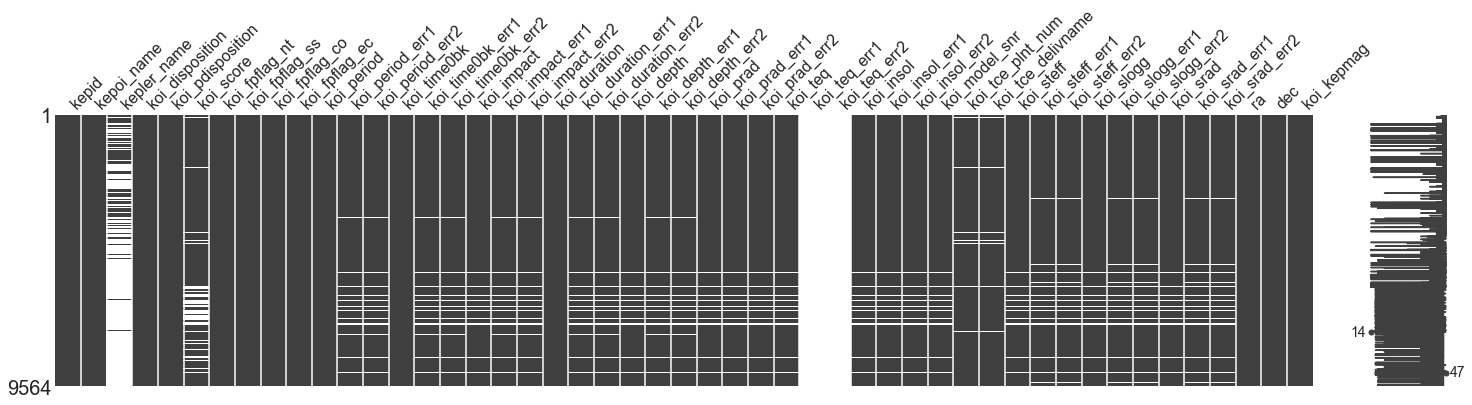

In [4]:
msno.matrix(df, figsize=(25,5))
plt.show()

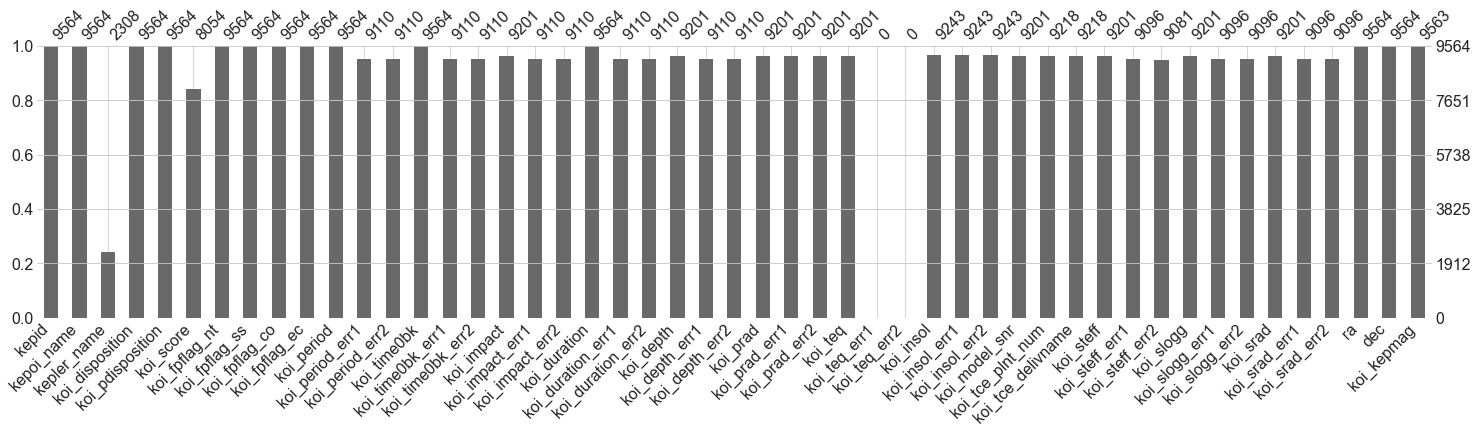

In [5]:
msno.bar(df, figsize=(25,5))
plt.show()

### Univariate Analysis<a class="anchor" id="section2_3"></a>

In [6]:
num = df.select_dtypes('number')
cat = df.select_dtypes('object')

There are numerical and categorical features in the data set. Thus, they are separated in two DataFrames so that different statistical characteristics of each of the features can be calculated.

In [7]:
num.shape, cat.shape

((9564, 44), (9564, 5))

In [8]:
num_summary = num.describe()
num_summary.loc['variance'] = num.var()
num_summary.loc['skewness'] = num.skew()
num_summary.loc['kurtosis'] = num.kurtosis()
num_summary.loc['IQR'] = num.quantile(q=0.75) - num.quantile(q=0.25)
num_summary.loc['range'] = num.max() - num.min()

if num.shape[1] <= 10:
    display(num_summary)
else:
    display(num_summary.transpose())

,count,mean,std,min,25%,50%,75%,max,variance,skewness,kurtosis,IQR,range
kepid,9564.0,7.690628e+06,2.653459e+06,7.574500e+05,5.556034e+06,7.906892e+06,9.873066e+06,1.293514e+07,7.040845e+12,-0.171807,-0.913690,4.317032e+06,1.217769e+07
koi_score,8054.0,4.808294e-01,4.769285e-01,0.000000e+00,0.000000e+00,3.340000e-01,9.980000e-01,1.000000e+00,2.274608e-01,0.056506,-1.939649,9.980000e-01,1.000000e+00
koi_fpflag_nt,9564.0,2.085947e-01,4.767290e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.650000e+02,2.272706e+01,96.930193,9451.187553,0.000000e+00,4.650000e+02
koi_fpflag_ss,9564.0,2.327478e-01,4.226049e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.785949e-01,1.265050,-0.399733,0.000000e+00,1.000000e+00
koi_fpflag_co,9564.0,1.975115e-01,3.981423e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.585173e-01,1.519817,0.309909,0.000000e+00,1.000000e+00
koi_fpflag_ec,9564.0,1.200335e-01,3.250176e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.056365e-01,2.338618,3.469858,0.000000e+00,1.000000e+00
koi_period,9564.0,7.567136e+01,1.334744e+03,2.418425e-01,2.733684e+00,9.752831e+00,4.071518e+01,1.299958e+05,1.781542e+06,96.459326,9389.730946,3.798149e+01,1.299955e+05
koi_period_err1,9110.0,2.147864e-03,8.236369e-03,0.000000e+00,5.345750e-06,3.520500e-05,2.762000e-04,1.725000e-01,6.783778e-05,8.516557,111.601933,2.708542e-04,1.725000e-01
koi_period_err2,9110.0,-2.147864e-03,8.236369e-03,-1.725000e-01,-2.762000e-04,-3.520500e-05,-5.345750e-06,0.000000e+00,6.783778e-05,-8.516557,111.601933,2.708542e-04,1.725000e-01
koi_time0bk,9564.0,1.661833e+02,6.791896e+01,1.205159e+02,1.327617e+02,1.372246e+02,1.706946e+02,1.472522e+03,4.612985e+03,3.682070,25.004265,3.793289e+01,1.352006e+03


In [9]:
rejected = 0
accepted = 0

for feature in num.columns:
    if num[feature].dropna().shape[0] >= 3: # Data must be at least length 3.
        p_value = stats.shapiro(num[feature].dropna())[1]
        if p_value <= 0.05:
            print(f'{feature} --- Null hypothesis of normality is rejected')
            rejected += 1
        else:
            print(f'{feature} --- Null hypothesis of normality is accepted')
            accepted += 1

print('\n')
print(f'Rejected hypotheses: {rejected}')
print(f'Accepted hypotheses: {accepted}')

kepid --- Null hypothesis of normality is rejected
koi_score --- Null hypothesis of normality is rejected
koi_fpflag_nt --- Null hypothesis of normality is rejected
koi_fpflag_ss --- Null hypothesis of normality is rejected
koi_fpflag_co --- Null hypothesis of normality is rejected
koi_fpflag_ec --- Null hypothesis of normality is rejected
koi_period --- Null hypothesis of normality is rejected
koi_period_err1 --- Null hypothesis of normality is rejected
koi_period_err2 --- Null hypothesis of normality is rejected
koi_time0bk --- Null hypothesis of normality is rejected
koi_time0bk_err1 --- Null hypothesis of normality is rejected
koi_time0bk_err2 --- Null hypothesis of normality is rejected
koi_impact --- Null hypothesis of normality is rejected
koi_impact_err1 --- Null hypothesis of normality is rejected
koi_impact_err2 --- Null hypothesis of normality is rejected
koi_duration --- Null hypothesis of normality is rejected
koi_duration_err1 --- Null hypothesis of normality is rejected


The null hypothesis of the Shapiro-Wilk test is used to estimate the probablity that the data is normally distributed. As it turns out, none of the data is normally distributed.

In [10]:
cat_summary = cat.describe()
if cat.shape[1] <= 10:
    display(cat_summary)
else:
    display(cat_summary.transpose())

,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_tce_delivname
count,9564,2308,9564,9564,9218
unique,9564,2308,3,2,3
top,K00752.01,Kepler-227 b,FALSE POSITIVE,FALSE POSITIVE,q1_q17_dr25_tce
freq,1,1,4840,4847,8054


In [11]:
for column in cat.columns:
    unique_values = cat[column].unique()
    number_values = len(unique_values)
    if number_values <= 10:
        print(f'Unique values of {column:<17} --- {number_values:<4} --- {unique_values}')
    else:
        print(f'Unique values of {column:<17} --- {number_values:<4}')

Unique values of kepoi_name        --- 9564
Unique values of kepler_name       --- 2309
Unique values of koi_disposition   --- 3    --- ['CONFIRMED' 'CANDIDATE' 'FALSE POSITIVE']
Unique values of koi_pdisposition  --- 2    --- ['CANDIDATE' 'FALSE POSITIVE']
Unique values of koi_tce_delivname --- 4    --- ['q1_q17_dr25_tce' 'q1_q16_tce' nan 'q1_q17_dr24_tce']


### Statistical graphical techniques<a class="anchor" id="section2_4"></a>

#### Univariate numerical and categorical data<a class="anchor" id="section2_4_1"></a>

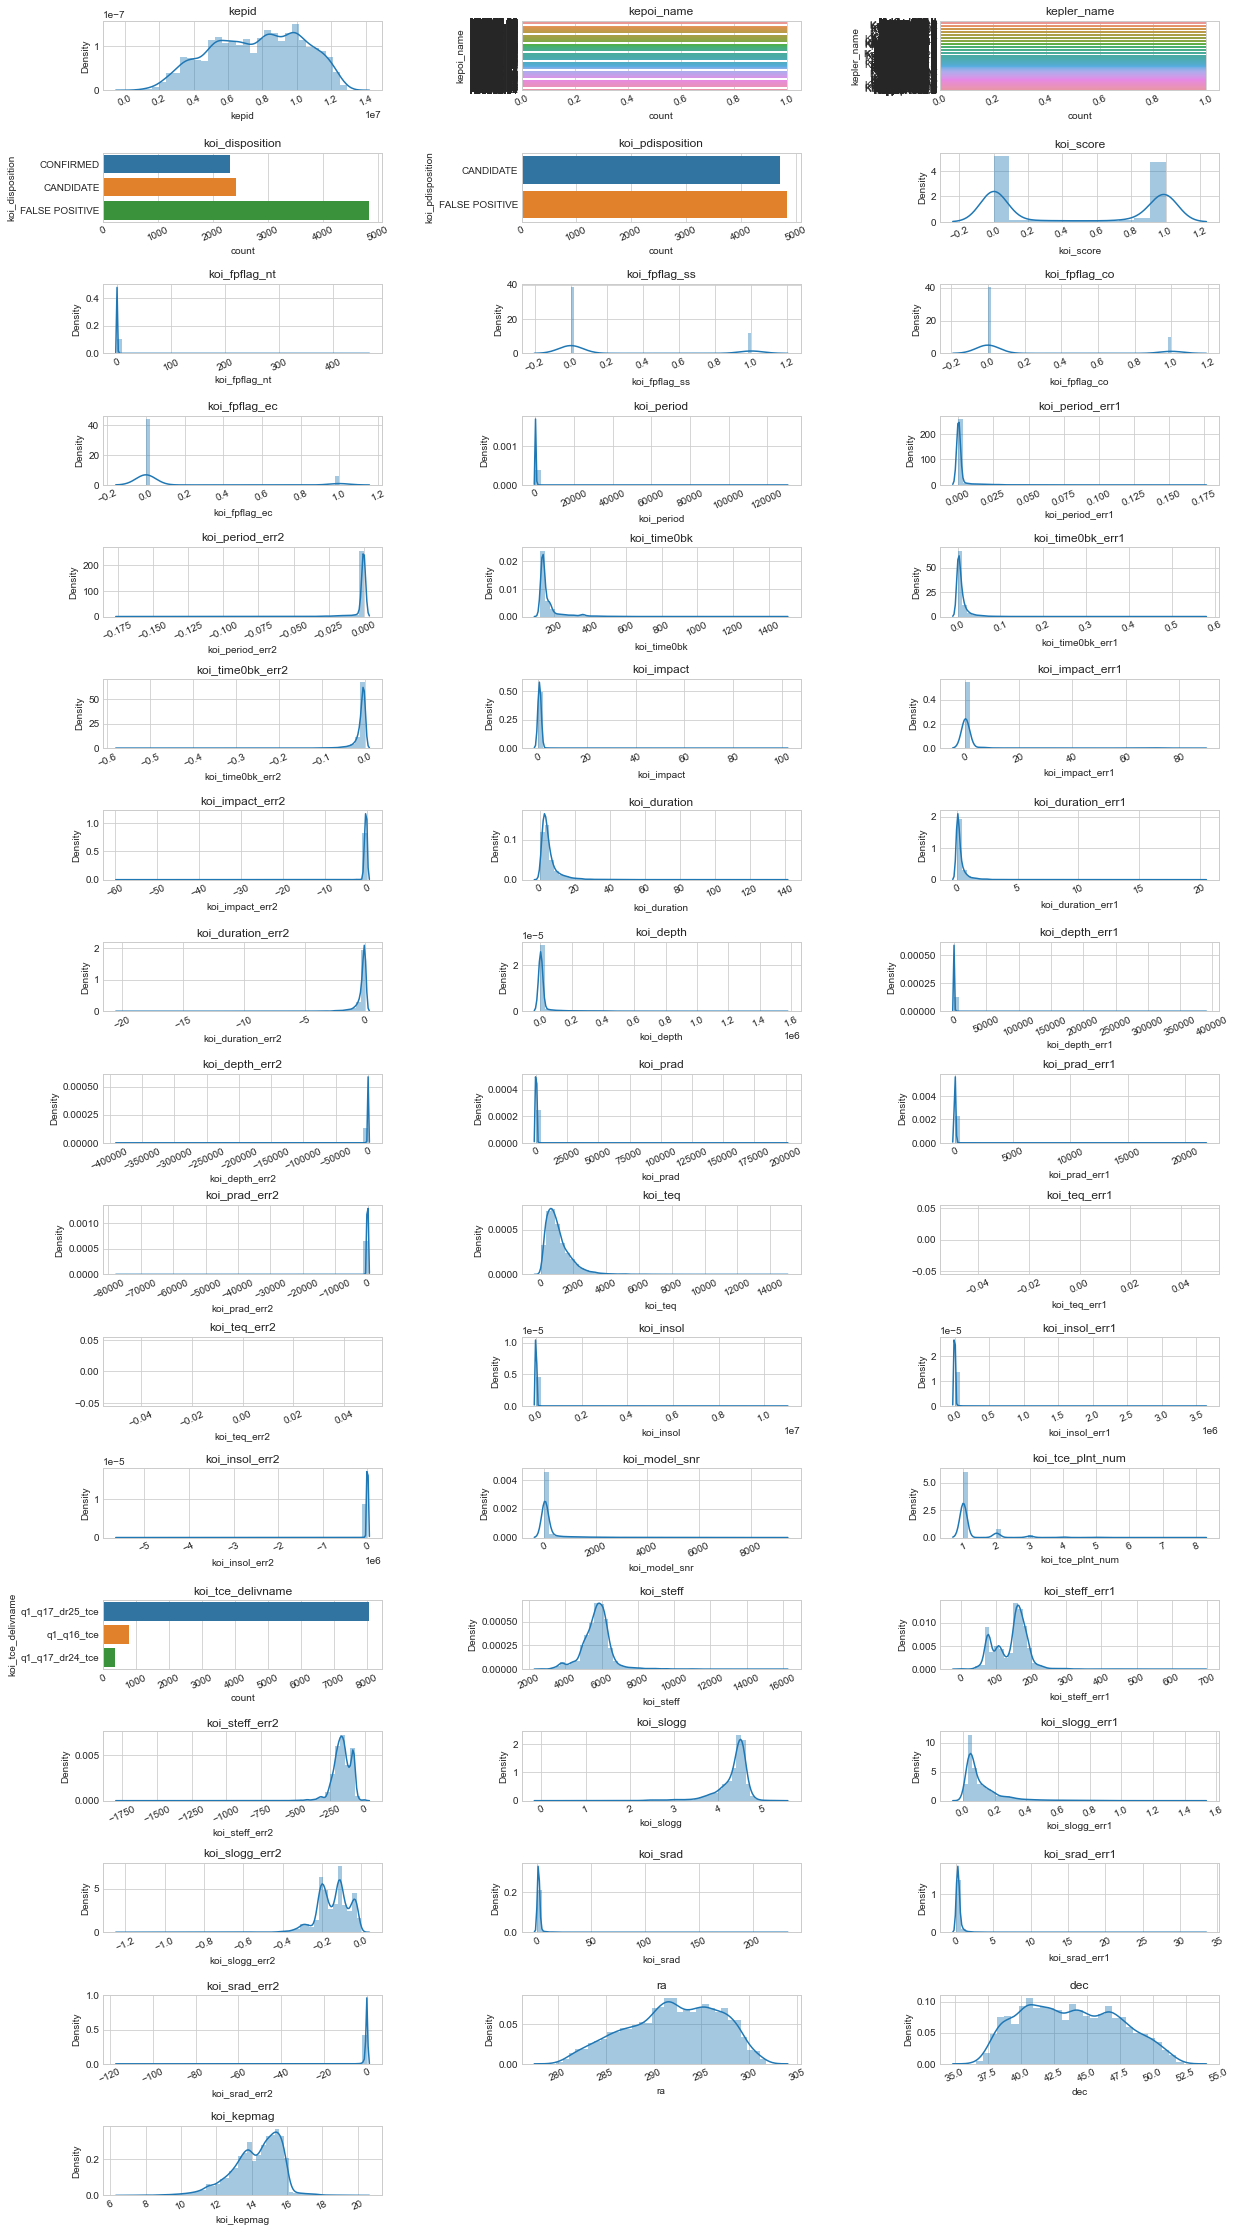

In [12]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = np.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(df, cols=3, width=20, height=40, hspace=0.9, wspace=0.5)

- There are outliers in almost every numerical features.
- As expected, they are not normally distributed which suggest that feature scaling should be applied.

**Note:** The code is taken from [here](https://github.com/dformoso/sklearn-classification/blob/master/Data%20Science%20Workbook%20-%20Census%20Income%20Dataset.ipynb).

#### Bivariate numerical data<a class="anchor" id="section2_4_2"></a>

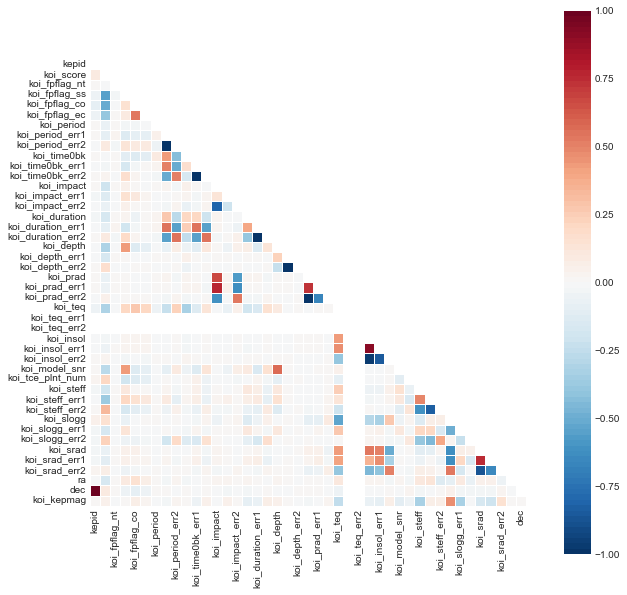

In [13]:
# Create a correlation plot of both datasets.
fig = plt.figure(figsize=(10,10)) 

# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask,
            linewidths=.5);

**Note:** The code is taken from [here](https://github.com/dformoso/sklearn-classification/blob/master/Data%20Science%20Workbook%20-%20Census%20Income%20Dataset.ipynb).

### Data Cleaning<a class="anchor" id="section2_5"></a>

In [14]:
exoplanets = df.loc[cumulative['koi_disposition'] != 'CANDIDATE']
candidates = df.loc[cumulative['koi_disposition'] == 'CANDIDATE']

From EDA, the target feature had three values: `CONFIRMED`, `FALSE POSITIVE`, and `CANDIDATE`. The data set is separated in two parts, where the first contains the examples that are labeled, and the second contains the examples that need to be classified with the models that are going to be built.

In [15]:
df_exo = exoplanets.copy()
df_can = candidates.copy()

- Because the data set is relatively big, the missing values are removed.
- The categorical data don't carry any information because they are features created by the scientist to uniquely identify the astronomical objects that were detected with the space telescope. Thus, they can be removed.
- The features `koi_teq_err1` and `koi_teq_err2` don't have any value, and they are removed. This is done before droping the other sporadic missing values in the data set, because if the method `dropna()` is applied before dropping them, the whole data set will be removed.
- These operations can be wrapped in a function.

In [16]:
def clean_data(df):
    '''
    Function to clean data
    '''
    df = df.copy()

    df.drop(columns=['kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_tce_delivname'], inplace=True) # artificial categorical data

    df.drop(columns = ['koi_teq_err1', 'koi_teq_err2'], inplace=True) # every value is missing
    
    df.dropna(axis=0, inplace=True)

    return df

In [17]:
exoplanets = clean_data(df_exo)

n_complete = df_exo.shape[0]
n_dropped = exoplanets.shape[0]

dropped_percentage = np.round((1 - n_dropped/n_complete)*100, 4)
print(f'Dropped rows: {n_complete-n_dropped} --- {dropped_percentage:.4f} %')

Dropped rows: 1130 --- 15.8130 %


### Class Distribution<a class="anchor" id="section2_6"></a>

In [18]:
def get_class_counts(df, feature):
    '''
    Function that returns the number of examples in each class
    '''
    classes = df[feature].unique()
    class_counts = dict()
    
    for c in classes:
        counts = df[df[feature] == c].shape[0]
        class_counts.update({c: counts})
    
    return class_counts

def get_class_proportions(df, feature):
    '''
    Function that returns the ratio of examples in each class (confirmed and false positive)
    '''
    class_counts = get_class_counts(df, feature)
    
    classes = df[feature].unique()
    total_examples = df[feature].shape[0]
    class_ratios = dict()
    
    for c in classes:
        ratio = np.round(df[df[feature] == c].shape[0] / total_examples, 4)*100
        class_ratios.update({c: ratio})
    
    return class_ratios

In [19]:
exoplanets_counts = get_class_counts(df=exoplanets, feature='koi_disposition')
exoplanets_ratios = get_class_proportions(df=exoplanets, feature='koi_disposition')

print(f'Data set class counts: {exoplanets_counts}')
print(f'Data set class ratios: {exoplanets_ratios}')

Data set class counts: {'CONFIRMED': 2281, 'FALSE POSITIVE': 3735}
Data set class ratios: {'CONFIRMED': 37.92, 'FALSE POSITIVE': 62.08}


Important thing to check when dealing with classification is if the data set is balanced or imbalanced. As it turns out, it is imbalanced, and stratification needs to be used.

### Splitting the Data Set into Train and Test Sets<a class="anchor" id="section2_7"></a>

In [20]:
test_size = 0.17

train, test = train_test_split(exoplanets, test_size=test_size, random_state=0, stratify=exoplanets['koi_disposition'])

In [21]:
train.shape[0], test.shape[0]

(4993, 1023)

In [22]:
train_class_counts = get_class_counts(df=train, feature='koi_disposition')
test_class_counts = get_class_counts(df=test, feature='koi_disposition')

train_class_ratios = get_class_proportions(df=train, feature='koi_disposition')
test_class_ratios = get_class_proportions(df=test, feature='koi_disposition')

print("Train class counts:", train_class_counts)
print("Test class counts:", test_class_counts)

print("Train class proportions:", train_class_ratios)
print("Test class proportions:", test_class_ratios)

Train class counts: {'FALSE POSITIVE': 3100, 'CONFIRMED': 1893}
Test class counts: {'FALSE POSITIVE': 635, 'CONFIRMED': 388}
Train class proportions: {'FALSE POSITIVE': 62.09, 'CONFIRMED': 37.91}
Test class proportions: {'FALSE POSITIVE': 62.07, 'CONFIRMED': 37.93}


In [23]:
def X_y_split(df, target):
    '''
    Function to split the data set in data and target
    '''
    X = df.drop(target, axis=1)
    y = df[target]
    return X, y

In [24]:
target = 'koi_disposition'

X_train, y_train = X_y_split(train, target)
X_test, y_test = X_y_split(test, target)

## Preprocessing<a class="anchor" id="chapter3"></a>

### Feature Selection<a class="anchor" id="section3_1"></a>

In [25]:
forest = ExtraTreesClassifier(n_estimators=50, random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [26]:
importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

In [27]:
importances

koi_score            0.436638
koi_fpflag_ss        0.172717
koi_fpflag_co        0.122845
koi_fpflag_ec        0.056031
koi_fpflag_nt        0.031297
koi_steff_err1       0.018552
koi_steff_err2       0.013544
koi_prad             0.012762
koi_period           0.010387
koi_depth            0.009418
koi_prad_err1        0.009368
koi_tce_plnt_num     0.009222
koi_teq              0.008367
koi_model_snr        0.006939
koi_slogg_err2       0.006035
koi_impact_err1      0.005641
koi_duration_err1    0.005563
koi_slogg            0.005337
koi_duration_err2    0.005210
koi_time0bk_err2     0.003738
ra                   0.003552
koi_duration         0.003304
koi_insol            0.003121
koi_depth_err1       0.003111
koi_prad_err2        0.002925
koi_period_err2      0.002874
koi_impact           0.002791
koi_depth_err2       0.002752
koi_steff            0.002698
koi_slogg_err1       0.002668
koi_insol_err2       0.002588
koi_time0bk_err1     0.002354
koi_srad_err2        0.002188
koi_impact

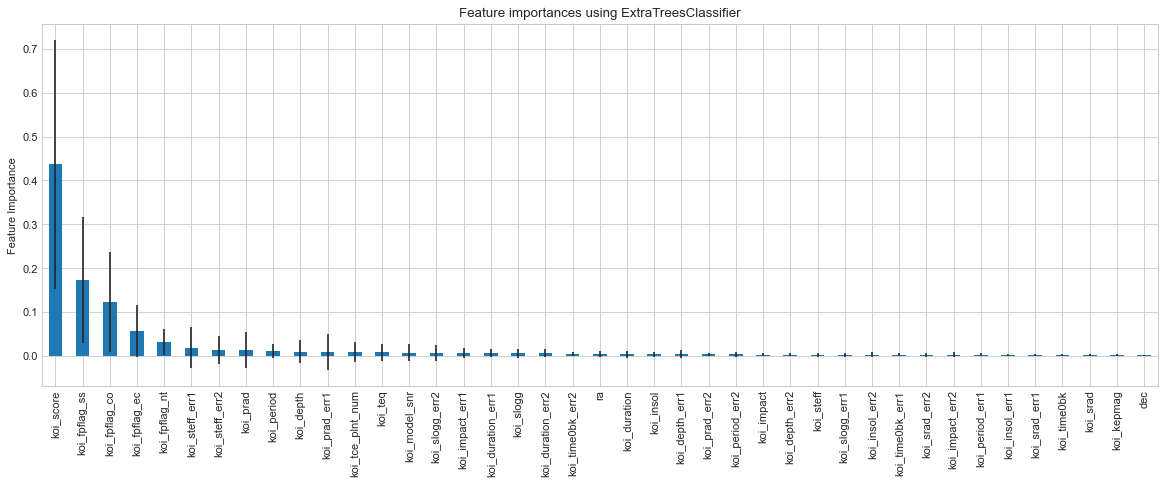

In [28]:
fig, ax = plt.subplots(figsize=(18, 6), dpi=80)
importances.plot.bar(yerr=std[indices], ax=ax)
ax.set_title('Feature importances using ExtraTreesClassifier')
ax.set_ylabel('Feature Importance')
plt.show()

### Data Preparation<a class="anchor" id="section3_2"></a>

In [29]:
preprocessor = Pipeline([
    ('standardization', StandardScaler()),
    ('feature-selection', SelectFromModel(ExtraTreesClassifier(n_estimators=50, random_state=0), threshold='median'))
])

In [30]:
preprocessor_tree = Pipeline([
    ('feature-selection', SelectFromModel(ExtraTreesClassifier(n_estimators=50, random_state=0), threshold='median'))
])

There are a lot of features, and not all of them are relevant for modeling. The most important features are determined with extra-trees classifier, and the threshold is the median of the feature importances.

### Label Encoding<a class="anchor" id="section3_3"></a>

Encoding the target.

In [31]:
le = LabelEncoder()

In [32]:
le.fit(y_train)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'CONFIRMED': 0, 'FALSE POSITIVE': 1}


In [33]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

## Models<a class="anchor" id="chapter4"></a>

### Training Model<a class="anchor" id="section4_1"></a>

Seven models are trained to predict whether an exoplanets was detected or not:
1. Naive Bayes,
2. Logistic Regression,
3. Support Vector Machines,
4. $k$-Nearest Neighbors,
5. Decision Trees,
6. Random Forest,
7. Stacking CV Classification.

We will use the following helper functions.

In [34]:
def train_classifier(model, X, y, cv):
    """
    Function to fit a classifier to the training data, and evaluate performance on train set
    """
    print(f'Trainig of model: {model.steps[1][1].__class__.__name__}')
    model.fit(X, y)
    
    score = cross_validate(model, X, y, scoring=['f1', 'roc_auc'], cv=cv, n_jobs=-1)
    
    print(f'Parameters: {model[1].get_params()}')
    print(score['test_f1'])
    print(f"Cross-validated F1 score: {np.nanmean(score['test_f1']):.4f} (+/-{np.nanstd(score['test_f1']):.4f})")
    print(f"Cross-validated AUC: {np.nanmean(score['test_roc_auc']):.4f} (+/-{np.nanstd(score['test_roc_auc']):.4f})")

Use `numpy`'s `nanmean()` and `nanstd()` methods to ignore the `nan` values in an array.

In [35]:
def grid_search(model, X, y, param_grid, cv):
    '''
    Function to optimize hyper-parameters of models with grid search
    '''
    
    t0 = time()
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=['f1', 'roc_auc'],
        n_jobs=-1,
        refit='f1',
        cv=cv
    ).fit(X, y)
    eval_time = time() - t0

    f1_mean = gs.cv_results_['mean_test_f1'][gs.best_index_]
    f1_std = gs.cv_results_['std_test_f1'][gs.best_index_]
    auc_mean = gs.cv_results_['mean_test_roc_auc'][gs.best_index_]
    auc_std = gs.cv_results_['std_test_roc_auc'][gs.best_index_]
    
    print(f'Best estimator: {gs.best_estimator_[1]}')
    print(f"Cross-validated F1 score: {f1_mean:.4f} (+/-{f1_std:.4f})")
    print(f"Cross-validated AUC: {auc_mean:.4f} (+/-{auc_std:.4f})")
    print(f'Evaluation time: {eval_time:.4f} seconds')

    return gs.best_estimator_

In [36]:
def randomized_search(model, X, y, param_distributions, n_iter, cv):
    '''
    Function to optimize hyper-parameters of models with randomized search
    '''
    
    t0 = time()
    rs = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring=['f1', 'roc_auc'],
        n_jobs=-1,
        refit='f1',
        cv=cv,
        random_state=0
    ).fit(X, y)
    eval_time = time() - t0

    f1_mean = rs.cv_results_['mean_test_f1'][rs.best_index_]
    f1_std = rs.cv_results_['std_test_f1'][rs.best_index_]
    auc_mean = rs.cv_results_['mean_test_roc_auc'][rs.best_index_]
    auc_std = rs.cv_results_['std_test_roc_auc'][rs.best_index_]
    
    print(f'Best estimator: {rs.best_estimator_[1]}')
    print(f"Cross-validated F1 score: {f1_mean:.4f} (+/-{f1_std:.4f})")
    print(f"Cross-validated AUC: {auc_mean:.4f} (+/-{auc_std:.4f})")
    print(f'Evaluation time: {eval_time:.4f} seconds')

    return rs.best_estimator_

In [37]:
shuffle_split = StratifiedShuffleSplit(test_size=0.15, n_splits=10)

### Naive Bayes<a class="anchor" id="section4_2"></a>

In [38]:
gnb_pipeline = Pipeline([('preprocessor', preprocessor), ('Naive-Bayes', GaussianNB())])

In [39]:
%%time

train_classifier(model=gnb_pipeline, X=X_train, y=y_train, cv=shuffle_split)

Trainig of model: GaussianNB
Parameters: {'priors': None, 'var_smoothing': 1e-09}
[0.98484848 0.98606645 0.98913043 0.98474946 0.98591549 0.99677766
 0.98808234 0.98488121 0.98594595 0.99464094]
Cross-validated F1 score: 0.9881 (+/-0.0041)
Cross-validated AUC: 0.9950 (+/-0.0022)
Wall time: 6.58 s


### Logistic Regression<a class="anchor" id="section4_3"></a>

In [40]:
logreg_pipeline = Pipeline([('preprocessor', preprocessor), ('Logistic-Regression', LogisticRegression())])

In [41]:
%%time

train_classifier(model=logreg_pipeline, X=X_train, y=y_train, cv=shuffle_split)

Trainig of model: LogisticRegression
Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
[0.99356223 0.98924731 0.99249732 0.99141631 0.98826041 0.99785408
 0.99033298 0.99033298 0.99249732 0.99462943]
Cross-validated F1 score: 0.9921 (+/-0.0027)
Cross-validated AUC: 0.9977 (+/-0.0015)
Wall time: 1.43 s


#### Hyperparameter Optimization of Logistic Regression

In [42]:
penalty = ['l1', 'l2', 'elasticnet', 'none']
C = [0.001, 0.01, 0.1, 1, 10, 100]

param_grid_LogisticRegression = {
    'Logistic-Regression__C': C,
    'Logistic-Regression__penalty': penalty
}

logreg_opt = grid_search(
    logreg_pipeline,
    X_train,
    y_train,
    param_grid_LogisticRegression,
    shuffle_split
)

Best estimator: LogisticRegression(C=0.001, penalty='none')
Cross-validated F1 score: 0.9924 (+/-0.0038)
Cross-validated AUC: 0.9983 (+/-0.0015)
Evaluation time: 14.8854 seconds


### Support Vector Machines<a class="anchor" id="section4_4"></a>

The `probability` parameter is set to `True` to be able to compute ROC and AUC.

In [43]:
svc_pipeline = Pipeline([('preprocessor', preprocessor), ('svc', SVC(probability=True))])

In [44]:
%%time

train_classifier(model=svc_pipeline, X=X_train, y=y_train, cv=shuffle_split)

Trainig of model: SVC
Parameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
[0.99249732 0.99465241 0.99249732 0.99249732 0.99356223 0.99568966
 0.99678457 0.99033298 0.98603652 0.99571734]
Cross-validated F1 score: 0.9930 (+/-0.0030)
Cross-validated AUC: 0.9985 (+/-0.0015)
Wall time: 4.65 s


#### Hyperparameter Optimization of Support Vector Machines

In [45]:
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 'auto', 'scale']
class_weight = ['balanced', None]

param_grid_SVC = {
    'svc__C': C,
    'svc__gamma': gamma,
    'svc__class_weight': class_weight
}

svc_opt = randomized_search(
    svc_pipeline,
    X_train,
    y_train,
    param_grid_SVC,
    n_iter=20,
    cv=shuffle_split
)

Best estimator: SVC(C=10, gamma='auto', probability=True)
Cross-validated F1 score: 0.9937 (+/-0.0019)
Cross-validated AUC: 0.9986 (+/-0.0013)
Evaluation time: 245.5476 seconds


### $k$-Nearest Neighbors<a class="anchor" id="section4_5"></a>

In [46]:
knn_pipeline = Pipeline([('preprocessor', preprocessor), ('knn', KNeighborsClassifier())])

In [47]:
train_classifier(model=knn_pipeline, X=X_train, y=y_train, cv=shuffle_split)

Trainig of model: KNeighborsClassifier
Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
[0.99784946 0.98927039 0.99465241 0.99139785 0.99354839 0.99031216
 0.98818475 0.98920086 0.99461787 0.99029126]
Cross-validated F1 score: 0.9919 (+/-0.0029)
Cross-validated AUC: 0.9947 (+/-0.0024)


#### Hyperparameter Optimization of $k$-Nearest Neighbors

In [48]:
n_neighbors = [2, 4, 8, 16, 32]
p = [1, 2, 3]

param_grid_KNeighborsClassifier = {
    'knn__n_neighbors': n_neighbors,
    'knn__p': p
}

knn_opt = grid_search(
    model=knn_pipeline,
    X=X_train,
    y=y_train,
    param_grid=param_grid_KNeighborsClassifier,
    cv=shuffle_split
)

Best estimator: KNeighborsClassifier(n_neighbors=8, p=1)
Cross-validated F1 score: 0.9924 (+/-0.0039)
Cross-validated AUC: 0.9971 (+/-0.0018)
Evaluation time: 54.4148 seconds


### Decision Trees<a class="anchor" id="section4_6"></a>

In [49]:
dt_pipeline = Pipeline([('preprocessor_tree', preprocessor_tree), ('dt', DecisionTreeClassifier())])

In [50]:
train_classifier(model=dt_pipeline, X=X_train, y=y_train, cv=shuffle_split)

Trainig of model: DecisionTreeClassifier
Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
[0.98275862 0.98600646 0.99461787 0.98815931 0.99677766 0.98922414
 0.98501071 0.99039488 0.98378378 0.99354839]
Cross-validated F1 score: 0.9890 (+/-0.0045)
Cross-validated AUC: 0.9855 (+/-0.0058)


#### Hyperparameter Optimization of Decision Trees

In [51]:
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(1, 100, num = 11)]
max_depth.append(None)
max_features = ['sqrt', 'log2', None]
class_weight = ['balanced', None]

param_grid_DecisionTreeClassifier = {
    'dt__criterion': criterion,
    'dt__max_depth': max_depth,
    'dt__max_features': max_features,
    'dt__class_weight': class_weight
}

dt_opt = randomized_search(
    dt_pipeline,
    X_train,
    y_train,
    param_grid_DecisionTreeClassifier,
    n_iter=20,
    cv=shuffle_split
)

Best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=60)
Cross-validated F1 score: 0.9942 (+/-0.0028)
Cross-validated AUC: 0.9922 (+/-0.0040)
Evaluation time: 12.0104 seconds


### Random Forest<a class="anchor" id="section4_7"></a>

In [52]:
rf_pipeline = Pipeline([('preprocessor_tree', preprocessor_tree), ('rf', RandomForestClassifier())])

In [53]:
train_classifier(model=rf_pipeline, X=X_train, y=y_train, cv=shuffle_split)

Trainig of model: RandomForestClassifier
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
[0.99464094 0.99570815 0.99571734 0.98723404 0.99464094 0.99357602
 0.99462943 0.99570815 0.99464094 0.99785408]
Cross-validated F1 score: 0.9944 (+/-0.0026)
Cross-validated AUC: 0.9996 (+/-0.0004)


#### Hyperparameter Optimization of Random Forest

In [54]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 15)]
max_depth = [5, 8, 15, 25, 30]
max_depth.append(None)
min_samples_split = [1, 2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]
max_features = ['log2', 'sqrt', None]
    
param_grid_RandomForestClassifier = {
    'rf__n_estimators': n_estimators,
    'rf__max_depth': max_depth,
    'rf__min_samples_split':  min_samples_split,
    'rf__min_samples_leaf': min_samples_leaf,
    'rf__max_features': max_features
}

rf_opt = randomized_search(
    rf_pipeline,
    X_train,
    y_train,
    param_grid_RandomForestClassifier,
    n_iter=20,
    cv=shuffle_split
)

Best estimator: RandomForestClassifier(max_depth=25, max_features='log2', n_estimators=1000)
Cross-validated F1 score: 0.9952 (+/-0.0023)
Cross-validated AUC: 0.9994 (+/-0.0011)
Evaluation time: 293.2864 seconds


### Stacking CV Classification<a class="anchor" id="section4_8"></a>

In [55]:
clf1 = knn_opt
clf2 = svc_opt
clf3 = dt_opt
lr = logreg_opt

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr,
                            random_state=0)

sclf_pipeline = Pipeline([('preprocessor', preprocessor), ('stacking', sclf)])

In [56]:
train_classifier(model=sclf_pipeline, X=X_train, y=y_train, cv=shuffle_split)

Trainig of model: StackingCVClassifier
Parameters: {'classifiers': [Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('standardization', StandardScaler()),
                                 ('feature-selection',
                                  SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=50,
                                                                                 random_state=0),
                                                  threshold='median'))])),
                ('knn', KNeighborsClassifier(n_neighbors=8, p=1))]), Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('standardization', StandardScaler()),
                                 ('feature-selection',
                                  SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=50,
                                                                                 random_state=0),
                                                  threshold='median'))])),
 

## Model Evaluation<a class="anchor" id="chapter5"></a>

The following evaluation metrics are used to determine the performance of each model:
- accuracy,
- precision,
- recall,
- $F_{1}$ score,
- ROC,
- AUC,
- confusion matrix.

As a single evaluation metric we use $F_1$ because the data set is imbalanced. The model with the highest $F_{1}$ score will be chosen for this application.

We will use the following helper functions.

In [57]:
def predict(model, X_test):
    """
    Function to predict class labels for samples in test data set
    """
    print(f'Predicting class labels of model: {model.steps[1][1].__class__.__name__}')
    y_pred = model.predict(X_test)
    return y_pred

def model_evaluation(model, X_test, y, y_pred):
    """
    Function to compute classification metrics using the F1 score and confusion matrix
    """
    Accuracy_score = accuracy_score(y, y_pred)
    Precision_score = precision_score(y, y_pred)
    Recall_score = recall_score(y, y_pred)
    F1_score = f1_score(y, y_pred)
    Roc_auc_score = roc_auc_score(y, model.predict_proba(X_test)[:, 1])
    
    print(f'Evaluation of model: {model.steps[1][1].__class__.__name__}')
    print(f'Accuracy score: {Accuracy_score:.4f}')
    print(f'Precision score: {Precision_score:.4f}')
    print(f'Recall score: {Recall_score:.4f}')
    print(f'F1 score: {F1_score:.4f}')
    print(f'AUC score: {Roc_auc_score:.4f}')
    
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()

    class_names = ['CONFIRMED', 'FALSE POSITIVE']
    cm = confusion_matrix(y_target=y, y_predicted=y_pred)
    ax = plot_confusion_matrix(conf_mat=cm,
                          show_absolute=True,
                          show_normed=True,
                          colorbar=True,
                          class_names=class_names
                         )
    plt.title('Confusion matrix')
    plt.show()
    
    return Accuracy_score, Precision_score, Recall_score, F1_score, Roc_auc_score

In [58]:
pipelines = [
    gnb_pipeline,
    logreg_opt,
    svc_opt,
    knn_opt,
    dt_opt,
    rf_opt,
    sclf_pipeline
]

Predicting class labels of model: GaussianNB
Evaluation of model: GaussianNB
Accuracy score: 0.9765
Precision score: 0.9904
Recall score: 0.9717
F1 score: 0.9809
AUC score: 0.9964


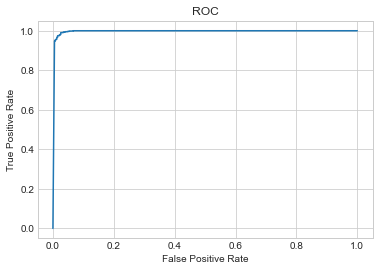

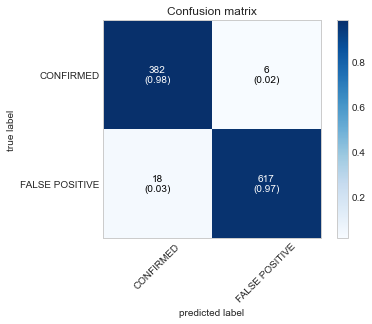




Predicting class labels of model: LogisticRegression
Evaluation of model: LogisticRegression
Accuracy score: 0.9892
Precision score: 0.9906
Recall score: 0.9921
F1 score: 0.9913
AUC score: 0.9993


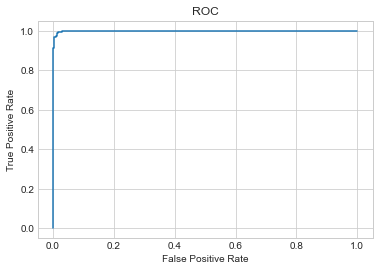

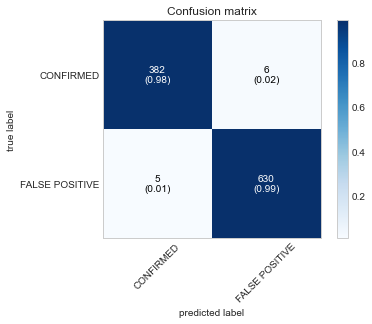




Predicting class labels of model: SVC
Evaluation of model: SVC
Accuracy score: 0.9912
Precision score: 0.9891
Recall score: 0.9969
F1 score: 0.9929
AUC score: 0.9985


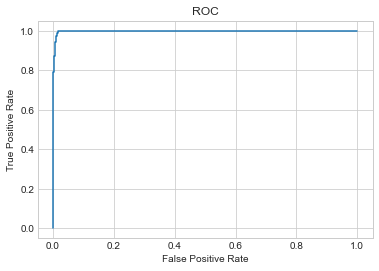

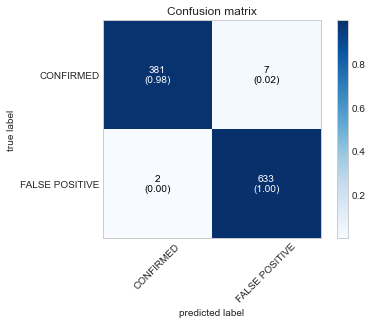




Predicting class labels of model: KNeighborsClassifier
Evaluation of model: KNeighborsClassifier
Accuracy score: 0.9834
Precision score: 0.9920
Recall score: 0.9811
F1 score: 0.9865
AUC score: 0.9974


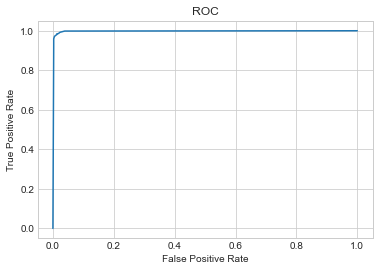

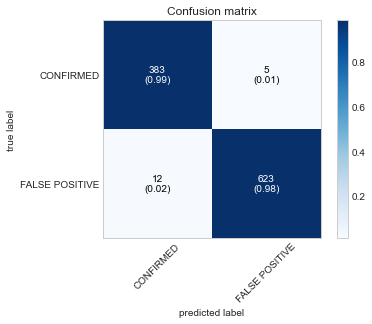




Predicting class labels of model: DecisionTreeClassifier
Evaluation of model: DecisionTreeClassifier
Accuracy score: 0.9932
Precision score: 0.9968
Recall score: 0.9921
F1 score: 0.9945
AUC score: 0.9935


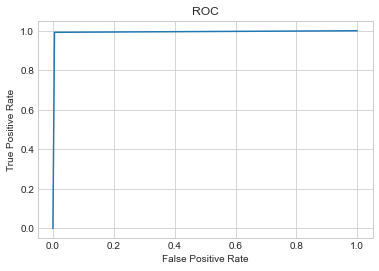

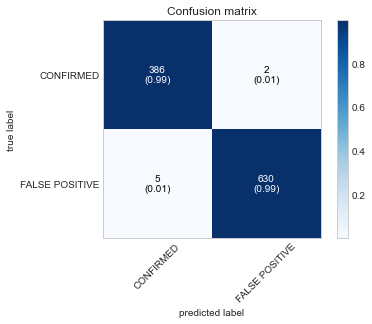




Predicting class labels of model: RandomForestClassifier
Evaluation of model: RandomForestClassifier
Accuracy score: 0.9961
Precision score: 0.9937
Recall score: 1.0000
F1 score: 0.9969
AUC score: 0.9998


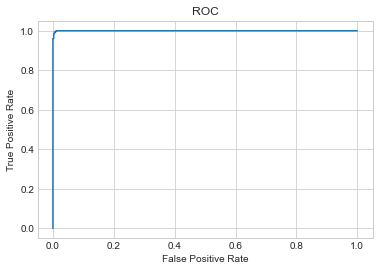

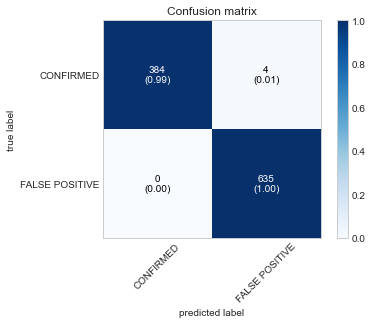




Predicting class labels of model: StackingCVClassifier
Evaluation of model: StackingCVClassifier
Accuracy score: 0.9961
Precision score: 0.9937
Recall score: 1.0000
F1 score: 0.9969
AUC score: 0.9974


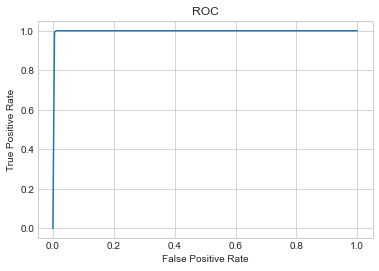

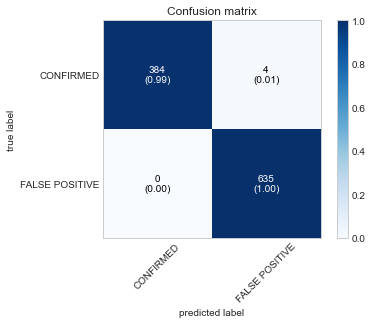

In [59]:
Models = []
Accuracy_scores = []
Precision_scores = []
Recall_scores = []
F1_scores = []
AUC_scores = []

for model in pipelines:
    print('='*50)
    y_pred = predict(model=model, X_test=X_test)
    
    Accuracy, Precision, Recall, F1, AUC = model_evaluation(model=model, X_test=X_test, y=y_test, y_pred=y_pred)
    
    Models.append(model.steps[1][1].__class__.__name__)
    Accuracy_scores.append(Accuracy)
    Precision_scores.append(Precision)
    Recall_scores.append(Recall)
    F1_scores.append(F1)
    AUC_scores.append(AUC)
    print('\n\n')

### Summary of model evaluation

In [60]:
metrics_summary = pd.DataFrame({
    'Model': Models,
    'Accuracy Score': Accuracy_scores,
    'Precision Score': Precision_scores,
    'Recall Score': Recall_scores,
    'F1 Score': F1_scores,
    'AUC Score': AUC_scores
})
metrics_summary.sort_values('F1 Score', ascending=False)

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score,AUC Score
5,RandomForestClassifier,0.996090,0.993740,1.000000,0.996860,0.999832
6,StackingCVClassifier,0.996090,0.993740,1.000000,0.996860,0.997382
4,DecisionTreeClassifier,0.993157,0.996835,0.992126,0.994475,0.993486
2,SVC,0.991202,0.989062,0.996850,0.992941,0.998466
1,LogisticRegression,0.989247,0.990566,0.992126,0.991345,0.999257
3,KNeighborsClassifier,0.983382,0.992038,0.981102,0.986540,0.997374
0,GaussianNB,0.976540,0.990369,0.971654,0.980922,0.996396


Random Forest has the highest $F_{1}$ score, so this is the chosen model.

## Discovering Exoplanets with the Chosen Model<a class="anchor" id="chapter6"></a>

In [61]:
def discover_possible_exoplanets(model, X_candidates, candidates):
    # Setting up confirmed and false positive array
    confirmed = []
    false_positive = []
    
    # Predicting the candidate exoplanets
    results = pd.Series(model.predict(X_candidates), index=candidates.index)
    candidates.insert(3, 'koi_disposition_pred', results)
    
    # Looping trough all the planets predictions
    for index, planet in candidates.iterrows():
        if planet['koi_disposition_pred'] == 0:
            confirmed.append({'name': planet['kepoi_name'], 'index': planet.index})
        else:
            false_positive.append({'name': planet['kepoi_name'], 'index': planet.index})

    discovery_rate = float(len(confirmed))/candidates.shape[0]*100

    print(f'\nExoplanets: {len(confirmed)} have been Confirmed')
    print(f'\nExoplanets: {len(false_positive)} are False Positive')
    print(f'\nDiscovery Rate: {discovery_rate:.4f}%')

The model is used with the function above to discover exoplanets.

**Note:** The code is adapted from [here](https://github.com/mitranos/exoplanets-discovery-machine-learning/blob/ac465cb8439deefe68242d86a1757415e00f4645/machine_learning_approach_to_exoplanet_discovery.ipynb).

In [62]:
candits = df_can.copy()

In [63]:
X_candits = candits.drop('koi_disposition', axis=1)
X_candits = clean_data(X_candits)

In [64]:
candits = pd.DataFrame(candits, index=X_candits.index)

In [65]:
discover_possible_exoplanets(model=rf_opt, X_candidates=X_candits, candidates=candits)


Exoplanets: 1542 have been Confirmed

Exoplanets: 245 are False Positive

Discovery Rate: 86.2899%


In [66]:
candits

,kepid,kepoi_name,kepler_name,koi_disposition_pred,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
2,10811496,K00753.01,NaN,1,CANDIDATE,CANDIDATE,0.000,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
37,11138155,K00760.01,NaN,0,CANDIDATE,CANDIDATE,1.000,0,0,0,...,-77.0,4.359,0.110,-0.110,1.082,0.173,-0.130,292.16705,48.727589,15.263
58,11818800,K00777.01,NaN,0,CANDIDATE,CANDIDATE,0.999,0,0,0,...,-163.0,4.507,0.116,-0.105,0.781,0.116,-0.095,294.31686,50.080231,15.487
62,11918099,K00780.02,NaN,0,CANDIDATE,CANDIDATE,0.993,0,0,0,...,-79.0,4.595,0.012,-0.064,0.765,0.055,-0.028,293.83331,50.230350,15.334
63,9579641,K00115.03,NaN,0,CANDIDATE,CANDIDATE,0.871,0,0,0,...,-115.0,4.339,0.132,-0.108,1.087,0.157,-0.142,287.88733,46.276241,12.791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9538,9938836,K07978.01,NaN,0,CANDIDATE,CANDIDATE,0.843,0,0,0,...,-242.0,3.890,0.405,-0.135,2.219,0.536,-0.996,285.30768,46.829803,13.729
9542,10011213,K07982.01,NaN,1,CANDIDATE,CANDIDATE,0.189,0,0,0,...,-225.0,4.488,0.054,-0.216,0.955,0.291,-0.097,291.60455,46.973289,15.632
9552,10028127,K08193.01,NaN,0,CANDIDATE,CANDIDATE,0.519,0,0,0,...,-166.0,4.561,0.030,-0.170,0.855,0.207,-0.069,297.73398,46.961529,15.719
9560,10128825,K07986.01,NaN,1,CANDIDATE,CANDIDATE,0.497,0,0,0,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757


The model, Random Forest, discovered 1,542 exoplanets, and the rest 245 are false positives, i.e., 86.2899% of the detected astronomical objects are exoplanets according to the model. According to this research, in total there are 3645 exoplanets, not taking into account the removed examples with missing data.

Kepler discovered 2,879 planets in total \[[3](#ref3)\]. In the exoplanets data set there are 2281 exoplanets, without taking into account the removed examples. Thus, there are 3823 exoplanets in total, or 32.7891% more discovered planets than there are actually reported. It is possible that something is not right in the data.

### Diagnosis and Discussion

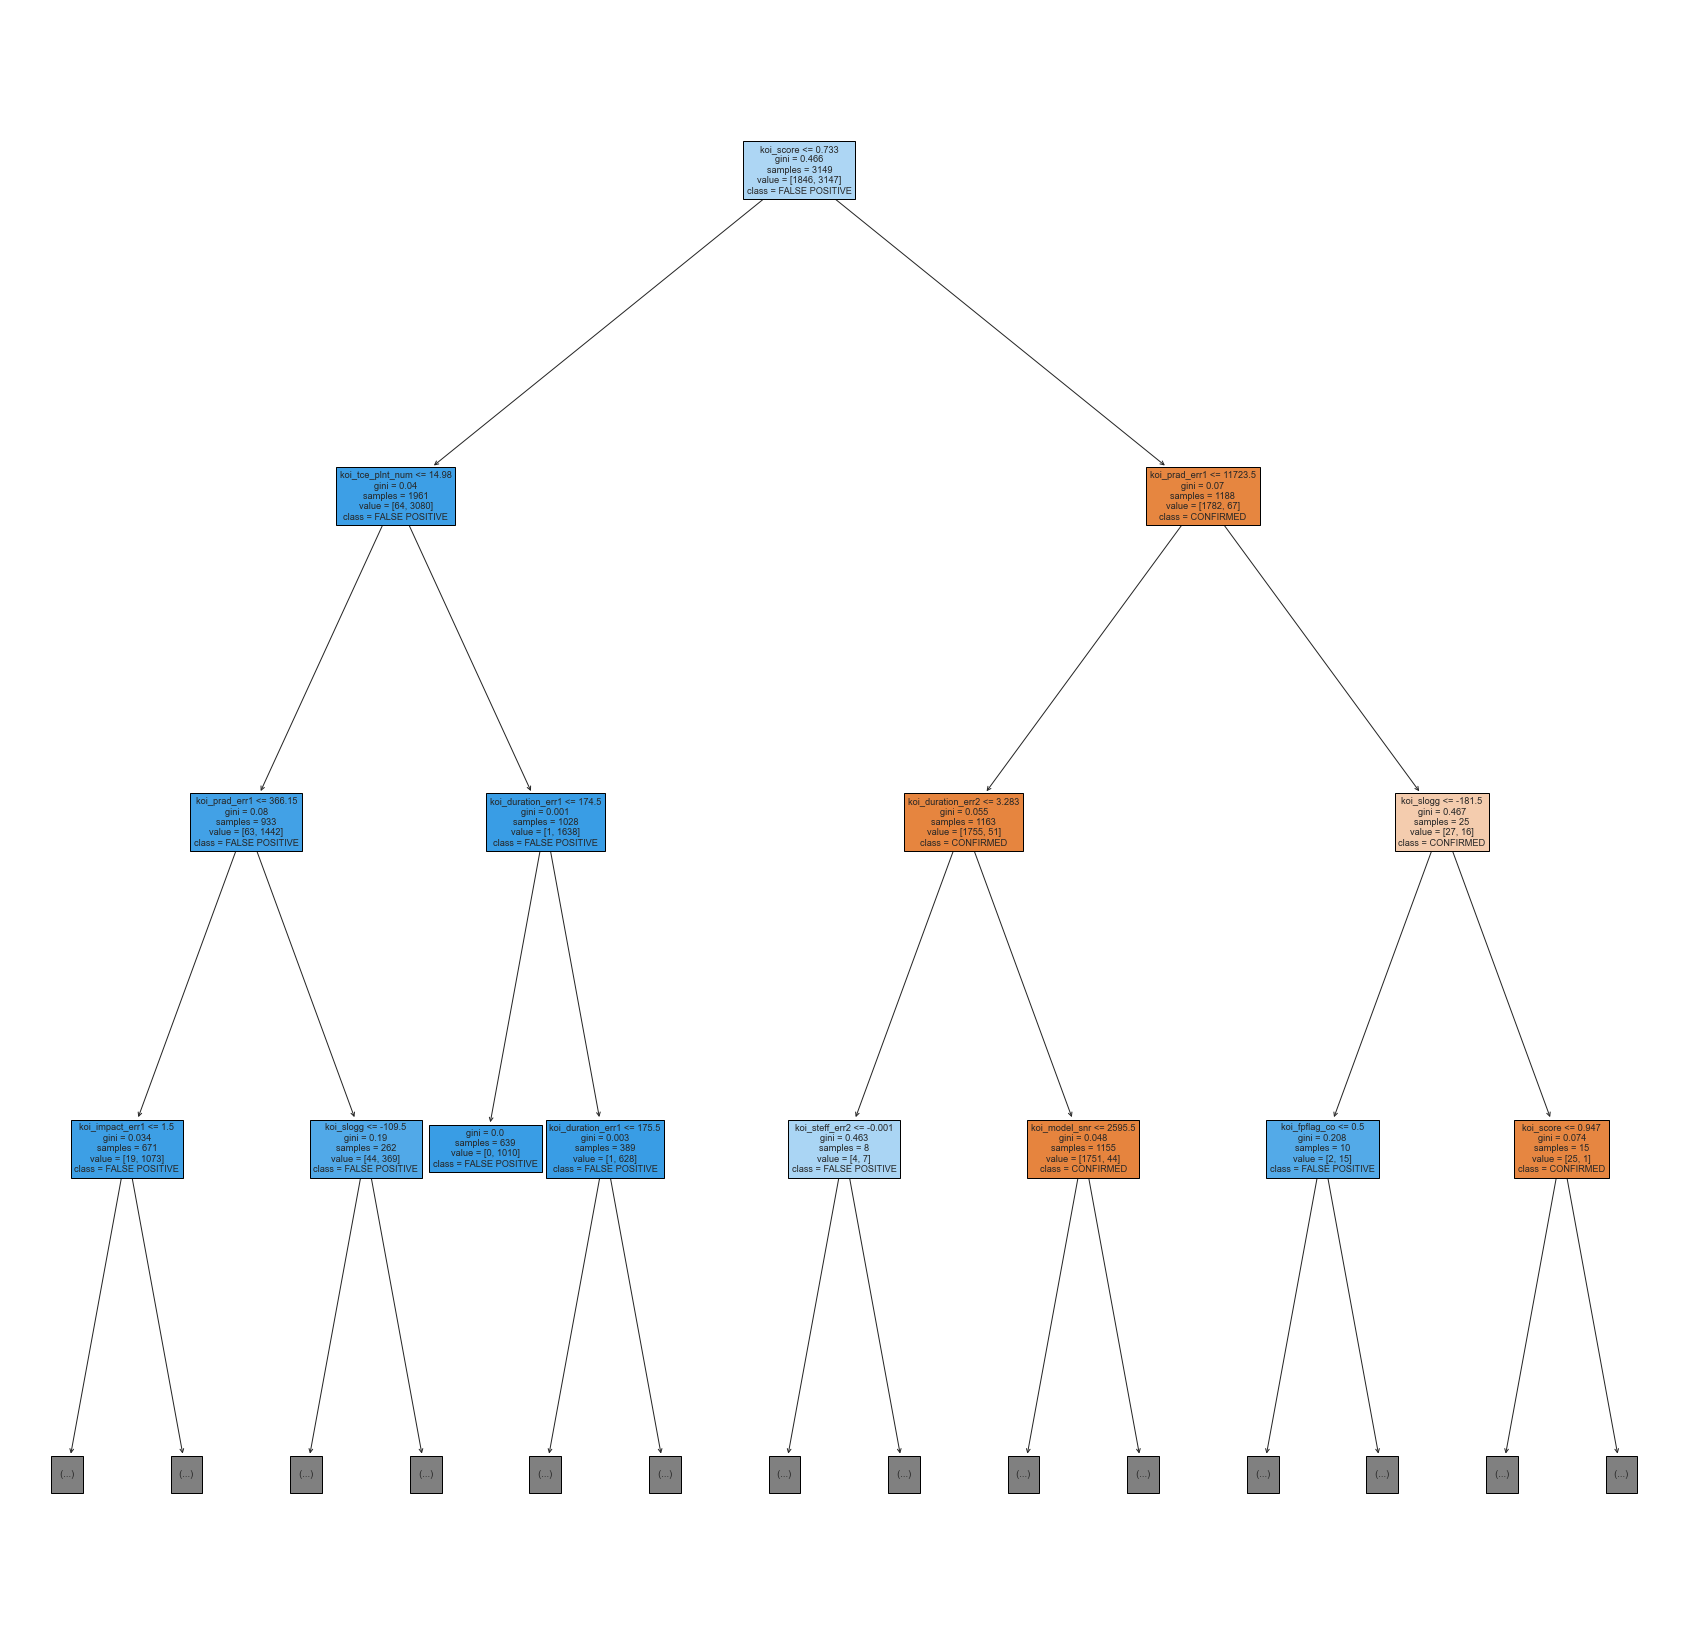

In [71]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(30,30))
plot_tree(
    decision_tree=rf_opt.steps[1][1].estimators_[4],
    max_depth=3,
    feature_names=importances.index[0:X_train.shape[1]],
    class_names=['CONFIRMED', 'FALSE POSITIVE'],
    filled=True
)
plt.show()

In [72]:
def check_distributions(feature_train, feature_test, feature_candidates, bins=10):
    fig = plt.subplots(1, 3, figsize=(10,5))
    
    plt.subplot(1,3,1)
    sns.histplot(feature_train, bins=bins)
    plt.xticks(np.arange(0, 1, step=0.1))

    plt.subplot(1,3,2)
    sns.histplot(feature_test, bins=bins)
    plt.xticks(np.arange(0, 1, step=0.1))

    plt.subplot(1,3,3)
    sns.histplot(feature_candidates, bins=bins)
    plt.xticks(np.arange(0, 1, step=0.1))

    plt.show()

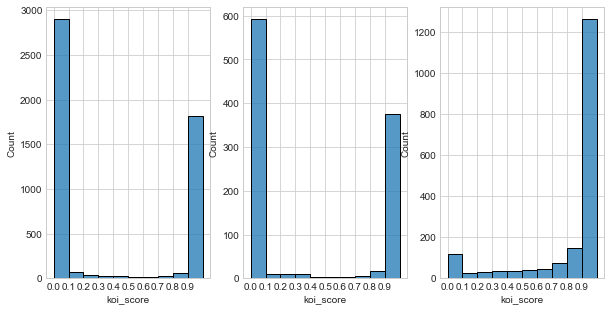

In [73]:
check_distributions(train['koi_score'], test['koi_score'], df_can['koi_score'])

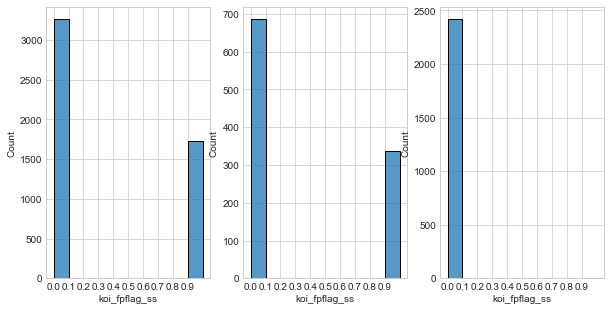

In [74]:
check_distributions(train['koi_fpflag_ss'], test['koi_fpflag_ss'], df_can['koi_fpflag_ss'])

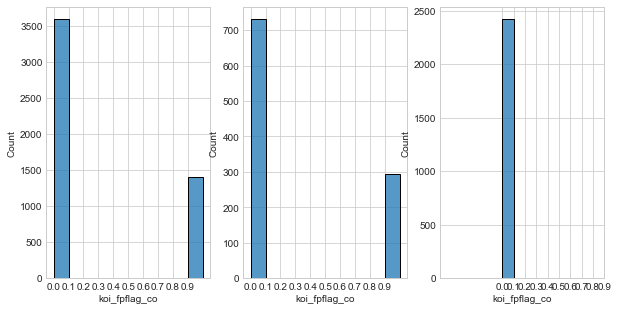

In [75]:
check_distributions(train['koi_fpflag_co'], test['koi_fpflag_co'], df_can['koi_fpflag_co'])

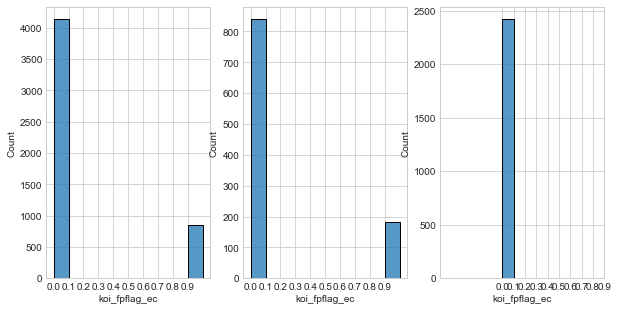

In [76]:
check_distributions(train['koi_fpflag_ec'], test['koi_fpflag_ec'], df_can['koi_fpflag_ec'])

In [77]:
df_can.loc[df_can['koi_score'] <= 0.733].shape[0], df_can.loc[df_can['koi_score'] >= 0.733].shape[0]

(353, 1463)

The diagnosis of the problem is that the feature `koi_score` (the disposition score) has the highest importance in the fifth tree, and it is the feature used for splitting the tree's root. The diagnostic histograms show that the majority of examples in the candidates data set (more than 1,200) have a value of the disposition score greater than or equal to $0.9$.

The root is split such that if $\text{disposition score}> 0.733$, as shown on the tree plot, those examples are more likely to be exoplanets. The number of such examples is 1,463, and the model spits out 1,542 discovered exoplanets. These numbers are similar, and this might explain why the total number od discovered exoplanets (3,823) doesn't make sence, i.e., it is not even remotely close to the published results (so far 2,879) by NASA.

The values of the disposition score are calculated from a Monte Carlo technique such that the score's value is equivalent to the fraction of iterations where the procedure called Robovetter \[[6](#ref6)\] yields a disposition of `CANDIDATE`. Even this procedure gives a higher disposition score to far more detected objects than there actually are.

In general, the most important features are clustered around a single value in the candidates data set, unlike the exoplanets data set, where the values are clumped around two different values which makes a more noticeable distinction whether it's an exoplanet or not, so the model is indiscriminately classifying objects with higher disposition score as exoplanets, even though it is obvious that's not the case.
 
It might be the case that Random Forest is not powerful enough to weed out the noise in the data and more advanced techniques are needed, for e.g. deep neural networks.

## References<a class="anchor" id="chapter7"></a>

[1] <a class="anchor" id="ref1"></a>Exoplanetarchive.ipac.caltech.edu. 2020. Kepler Objects Of Interest. [online] Available at: <https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative> [Accessed 30 August 2020].

[2] <a class="anchor" id="ref2"></a>Exoplanetarchive.ipac.caltech.edu. 2020. Data Columns In Kepler Objects Of Interest Table. [online] Available at: <https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html> [Accessed 30 August 2020].

[3] <a class="anchor" id="ref3"></a>Exoplanetarchive.ipac.caltech.edu. 2020. Data Columns In Kepler Objects Of Interest Table. [online] Available at: <https://exoplanets.nasa.gov/discovery/exoplanet-catalog/> [Accessed 3 December 2021].

[4] <a class="anchor" id="ref4"></a>Müller, A. and Guido, S., 2016. Introduction To Machine Learning With Python: A Guide For Data Scientists. 1st ed. O'Reilly Media.

[5] <a class="anchor" id="ref5"></a>Thakur, A., 2020. Approaching (almost) any machine learning problem. 1st ed. Abhishek Thakur.

[6] <a class="anchor" id="ref6"></a>Jeffrey L. Coughlin et al 2016 ApJS **224** 12